In [3]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)

Downloaded dataset Baby and saved it to ./data/


In [10]:

import  json

def  load_data (dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(baby[9426])
#for i, l in enumerate(baby):
#    if l['overall'] == 5.0 and 'horrible' in l['reviewText'] and 'bad' in l['reviewText'] and l['helpful'][0]>0:
#        print(i, l['reviewText'])

Loaded 160792 data for dataset Baby
{'reviewerID': 'A2H4QWDVXARPAU', 'asin': 'B0000TYHD2', 'reviewerName': 'Erin White "Erin"', 'helpful': [7, 8], 'reviewText': "I bought this pump for my new baby because it just as others below have said it looks more comfortable than others and it is! Including Medela. With my other child I encountered breastfeeding problems and had a horrible cheap pump. Now with my new baby she was born with a heart problem (she is fine now after a long road to recovery) and had to stay in the hospital for an extended length of time. Meanwhile I had other children at home and we live 6 hours away from our family and so I had no choice but to divide my time between the hospital and home, which meant I needed a hospital grade pump originally I rented one from the hospital (Medela) and it made my breasts hurt really bad. On the way home from the hospital I stopped in at Babiesrus and bought this pump because it was on our registry (we studied and found it to be more c

In [11]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print("Now we have", len(baby_train), "training examples,", len(baby_valid),
      "validation examples, and", len(baby_test), "test examples")


Now we have 96794 training examples, 31821 validation examples, and 32177 test examples


In [12]:
from  nltk.corpus  import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words
print("Words that appear in both sets: " + ", ".join(intersection))

Some positive words: gaiety, willing, eyecatch, humility, beckoned, enticingly, glamorous, feature-rich, delightfully, exult
Some negative words: unspeakable, confrontation, incitement, traumatic, fabrication, buckle, critic, ripped, ineptitude, powerless
Words that appear in both sets: envious, enviously, enviousness


In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))



(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [14]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 10538
{'reviewerID': 'A2FPJGVT01TVVQ', 'asin': 'B000A88JYQ', 'reviewerName': 'S. Broderick "Sondra"', 'helpful': [0, 0], 'reviewText': 'work perfect', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': -1899672876}
We found a fraction of 100.000000 % negative words for example 57458
{'reviewerID': 'A1LE9FNWTAN84U', 'asin': 'B003I68SFC', 'reviewerName': 'Marta', 'helpful': [0, 0], 'reviewText': 'They leak very bad!', 'overall': 1.0, 'summary': 'Leak!!!!', 'unixReviewTime': 1404950400, 'reviewTime': '07 10, 2014', 'hash': 2123499085}


In [15]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96794, 2)
Our target vector is one-dimensional and has shape (96794,)


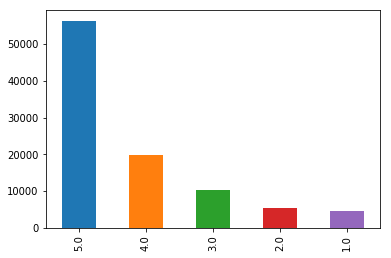

In [17]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

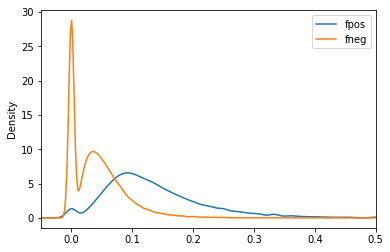

In [19]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [22]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.17415678414925
The coefficient for the fneg variable is -5.677160633346141
The intercept is 4.020708682852034


In [23]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.655540 stars
This is the same as 4.655540 stars


In [24]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 2.885277 stars
This is the same as 2.885277 stars


In [25]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

In [26]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]:
    analyze_training_example(i)

Training example number 0
True rating = 5.000000 stars, expected rating = 4.373393 stars
Features = 0.111111 / 0.000000
Review text = Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!
Training example number 10000
True rating = 5.000000 stars, expected rating = 4.095281 stars
Features = 0.222222 / 0.111111
Review text = I know that my son is nice and warm when he is in this.  Helps us go out on cold days.
Training example number 20000
True rating = 5.000000 stars, expected rating = 3.901151 stars
Features = 0.066667 / 0.058333
Review text = We tried several of our friends car seats in our vehicle before buying one, and I was shocked at how loose and unstable most of them were after being strapped in place, even using the LATCH system.  The Chicco, however, is completely different.  It 

In [27]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.827637 stars
